# HCI 2017 Week 4 - Coronagraphs Part II
*Matthew Kenworthy // Leiden Observatory*

Today we cover encircled energy plots and diffrent telescope PSFs.

**IMPORTANT** it is okay to cut and paste and reuse code from your previous Practicums! I am not expecting you to type everything out again. You now have developed your own codes and plotting routines, please reuse them if you can. This is what most researchers do from day to day.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def displC(c,trim=0):
    # displC - display a Complex number c as four plots
    #          as a (Real, Imaginary) pair and as
    #          an Amplitude, Phase plot
    #          optionally cut out the central square with size trim by trim pixels   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()
    
def plotCAmpl(Iorig, GAMMA=4, RANGE=None, plotnow=True, trim=0):
    """ display a complex valued image

    takes complex 2D array as input, returns an
    [N,3] RGB image for display

    if RANGE=(min,max) is given, it will set image intensity
    to 0 and 1 for these values and BLACK and WHITE
    colours for out of range amplitude values respectively

    the returned image has AMPLITUDE as brightness and
    PHASE as colour:

    RED    YELLOW   BLUE   GREEN
    0        90     180     270  degrees phase

    The image is scaled by a GAMMA factor (defaults to 4)
    to emphasize smaller amplitudes

    Set plotnow=False to stop display

    Returns a MxNx3 image suitable for display

    """
    import numpy as np
    PI = 4 * np.arctan(1)
    I = np.copy(Iorig)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = I.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        I = I[dx:dx+trim,dy:dy+trim]
        
    # calculate amplitude
    ampl = (abs(I)).real

    if RANGE is None:
        ampl = ampl / np.amax(ampl)
    else:
        ampl = (ampl - RANGE[0]) / abs(RANGE[1] - RANGE[0])
        ampOVER  = (ampl > 1)
        ampUNDER = (ampl < 0)
        ampl[ampOVER]  = 1
        ampl[ampUNDER] = 0

    # apply gamma to amplitude
    ampl = np.power(ampl, 1./GAMMA)

    # normalise phase from 0 to 1
    phse = (np.angle(I) / (2*PI)) + 0.5

    # make an RGB array
    img = np.zeros((I.shape[0], I.shape[1], 3), dtype=float)

    # red
    red = abs(phse - 0.625) * 4 - 0.5
    red = np.maximum(red, 0)
    red = np.minimum(red, 1)

    # green
    grn = 2 - abs(phse - 0.5) * 4
    tmp = np.where(grn > 1)
    grn[tmp] = 2. - grn[tmp]

    # blue
    blu = 1 - abs(phse - 0.5) * 4
    blu = np.maximum(blu, 0)

    img[:,:,0] = ampl * red
    img[:,:,1] = ampl * grn
    img[:,:,2] = ampl * blu

    # mark out of range points with RGB color
    if RANGE:
        img[ampOVER,:]  = (1,1,1)
        img[ampUNDER,:] = (0,0,0)

    if plotnow:
        # modified for ipython notebooks
        plt.imshow(img, aspect='equal',vmin = 0., vmax = 1., interpolation='nearest')

    return(img)



def padcplx(c,pad=5):
    # padcplx - puts a Complex array in the centre of a zero-filled Complex array
    #           pad defines the padding multiplier for the output array
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = int((nx * (pad-1)) / 2)
    dy = int((ny * (pad-1)) / 2)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(cb,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfB = fftshift(ifft2(ifftshift(padcplx(cb,pad))))
    return psfB

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def coro(A, m, N, nsamp):
    B = FFT(A,nsamp)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)

    return(B,C,D,E,F)
 

In [2]:
# you can use your own routines if you prefer

def Isum(c):
    return (np.sum(c * c.conjugate()).real)

# def xaxis_energy(im, xr):
#     ny, nx = im.shape
#     xc = int((nx-1) / 2.)
#     yc = int((ny-1) / 2.)
#     sli = im[yc,xc-xr:xc+xr+1]
#     return((sli*np.conjugate(sli)).real)

def xaxis_energy(im, xr):
    xcen = int(im.shape[1]/2)
    xvals = np.arange(xcen-xr,xcen+xr)
    clip_vals = im[xcen,xcen-xr:xcen+xr]
    clip_energy = np.abs(clip_vals)
    im_return = clip_energy*clip_energy
    return im_return,xvals

def ee(im, xc, yc, r_ap):
    r, t = r_theta(im, xc, yc)
    
    eout = np.zeros_like(r_ap)
    
    for i, rnow in enumerate(r_ap):
        eout[i] = Isum(im * (r < rnow))
    
    return(eout)

def E_to_I(im):
    I_star = np.abs(im)
    I_star = I_star * I_star
    return I_star
    

## Encircled Energy part 2
You've calculated the PSF profile and encircled energy for filled circular telescope pupils.

Many telescopes have a large primary mirror that reflects the light onto a secondary mirror, which then forms the focus of the telescope at either a Cassegrain, Gregorian, or Naysmith focus. The secondary mirror blocks light from the centre of the primary telescope, along with the shadows of the secondary support struts that hold the secondary mirror above the primary mirror. This is referred to as the *secondary obscuration*.

Assume the same telescope pupil geometry as in Week 3 - 101 by 101 pixels on a square array with the pupil touching all four edges of the square, and label it `A`, with a total intensity of `100.0` energy units.

**Q1 (6 points):** Calculate encircled energy plots for 0, 15, and 30 percent secondary obscuration in the center of the telescope pupil. Assume the secondary obscuration is circular and concentric with the telescope pupil and is completely opaque (amplitude is zero). Normalise the peak of each of the PSFs to unity before plotting them. Overplot all three curves on the same plot. 0 to 10 $\lambda/D$. Start from a radius of 1 pixel to avoid a divide by zero error.

What is the encircled energy at 1.22 $\lambda/D$ for all three secondary obscuration sizes?

**Q2 (2 points):** What happens to the relative intensities of the first and second Airy rings as the secondary obscuration size increases?

**Q3 (2 points):** Why do the diffraction minima not move significantly as the secondary obscuration increases?


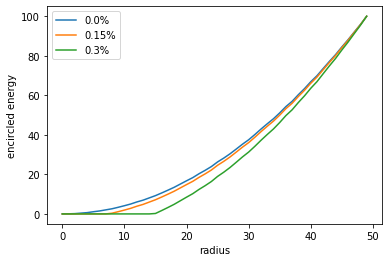

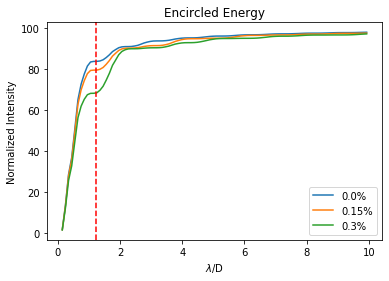

In [3]:
dtel = 101 # diameter of telescope pupil in pixels
nsamp = 7
Itotal = 100.0
dtel_samp = dtel*nsamp

### write answers below here

# code here

def obscure_pupil(M2):
    amp = 1*circle_mask(np.zeros((dtel,dtel)),dtel/2,dtel/2,dtel/2)
    #secondary obscuration
    amp -= circle_mask(np.zeros((dtel,dtel)),dtel/2,dtel/2,M2*dtel/2)
    phase = np.zeros_like(amp)
    A = amp * np.exp(1j*phase)
    A *= np.sqrt(Itotal) / np.sqrt(Isum(A))
    return A

# Q1 answer
obscure_percentage = [0.,0.15,0.3]

A_list = []

for i in range(len(obscure_percentage)):
    A_list.append(obscure_pupil(obscure_percentage[i]))
    
radii_axis = np.arange(1,)
    
for i in range(len(A_list)):
    plt.plot(ee(A_list[i],dtel/2,dtel/2,np.linspace(0,dtel/2)),
             label = str(obscure_percentage[i])+'%')
plt.xlabel('radius')
plt.ylabel('encircled energy')
plt.legend()
plt.show()

B_list = []

focal_radii = np.linspace(1,0.5*dtel_samp,500)
samp_radii = focal_radii / nsamp
max_radii = 10.

plt.clf()
for i in range(len(A_list)):
    B_focal = FFT(A_list[i],nsamp)
    B_focal /= np.sqrt(B_focal.size)
    B_list.append(B_focal)
    cir_energy = ee(B_focal,int(dtel_samp/2.),int(dtel_samp/2.),focal_radii)
    plt.plot(samp_radii[(samp_radii<max_radii)],cir_energy[(samp_radii<max_radii)], 
             label = str(obscure_percentage[i])+'%')

plt.axvline(1.22,linestyle = '--',color='r')
plt.xlabel('$\lambda$/D')
plt.ylabel('Normalized Intensity')
plt.title('Encircled Energy')
plt.legend()
plt.show()


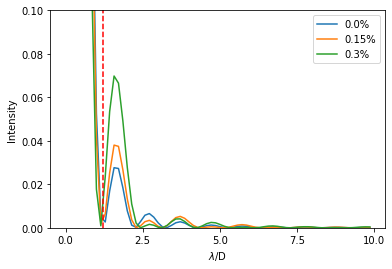

The relative intensity of the first and second Airy rings increase with an increase in secondary obscuration


In [4]:
# Q2 answer

B_I = []
img_cen = int(B_list[0].shape[0] / 2.)
# displC(B_list[0])

plt.clf()
for i in range(len(B_list)):
    I_B = E_to_I(B_list[i])
    plt.plot(I_B[img_cen,:][img_cen:img_cen+70],
             label = str(obscure_percentage[i])+'%')
plt.xticks(np.linspace(0,10*nsamp,5),np.linspace(0,10*nsamp,5)/nsamp)
plt.ylim(0,0.1)
plt.axvline(1.22*nsamp,linestyle = '--',color='r')
plt.xlabel('$\lambda$/D')
plt.ylabel('Intensity')
plt.legend()
plt.show()

print('The relative intensity of the first and second Airy rings increase with',
      'an increase in secondary obscuration')

In [5]:
# Q3 answer
print('The size of the Airy disk is dependant lambda not the size of the secondary')

The size of the Airy disk is dependant lambda not the size of the secondary


Add secondary supports to the telescope pupil. There should be four of them, equally spaced around the circumference of the telescope pupil, connecting the edges of the primary mirror to the secondary mirror. All four secondary mirror supports should have a width of 5% of the telescope pupil's diameter.

**Q4 (5 points):** Make three PSF images, and display them using `plotCAmpl(xxx,trim=71)`:

  * The unobstructed pupil
  * the pupil with 20% secondary obscuration (which means that the diameter of the secondary obscuration is 20% of the diameter of the primary mirror).
  * The pupil with 20% obscuration and the seconday supports described above.

 What is the effect of the secondary support structures in the PSF?

Pupil Plane


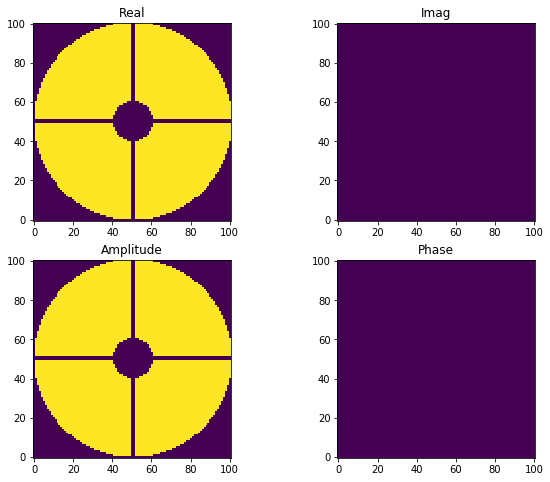

Focal Plane


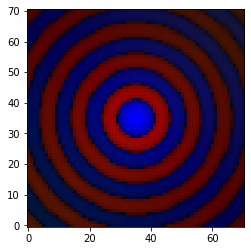

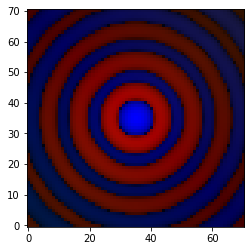

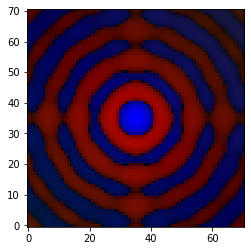

The secondary support structures adds disruption to the Airy rings and adds some "bumps" to the intensity rings


In [6]:
# code here

def make_support(im):
    A = im.copy()
    A[:,1+int((dtel - 0.025*dtel)/2.) : 1+int((dtel+0.025*dtel)/2)] = 0.0
    A[1+int((dtel - 0.025*dtel)/2.) : 1+int((dtel+0.025*dtel)/2),:] = 0.0
    return A
# Q4 answer here

A0 = obscure_pupil(0.0)
A20 = obscure_pupil(0.2)
A20_support = make_support(A20)
print('Pupil Plane')
displC(A20_support)

q5_list = [A0,A20,A20_support]

print('Focal Plane')
for i in range(len(q5_list)):
    plotCAmpl(FFT(q5_list[i]), trim = 71)
    plt.show()
    
print('The secondary support structures adds disruption to the Airy rings',
     'and adds some "bumps" to the intensity rings')

## More Coronagraphs and the effect of Secondary Obscurations

Last time, you saw that the Lyot coronagraph can suppress on-axis sources. This week, we will look at two other coronagraphs that are used in modern telescopes both on the ground and proposed for space missions. These are some of the *small angle coronagraphs* which can image planets and disks around stars at small angular separations.

### Vortex (focal plane) coronagraph

In the focal plane mask `m`, a phase ramp is added going from 0 to $n\pi$ radians around a central point, where $n$ denotes the *order* of the vortex. The star is put on the central point of the vortex mask, with the planet off to one side. 

A pupil mask `N` then masks out as much of the starlight as possible, while maximising the amount of planet light passing through to the final focal plane `F`.

Calculate the on-axis transmission for the $n=4$ vortex coronagraph and off-axis transmission for a planet at $3 \lambda/D$ which is 10000 times fainter in intensity than the central star.

Display the pupil at position `D` in the vortex coronagraph for the star and the planet with `displC(xxx,151)`.

**Q5 (2 points):** What has happened to the flux of the star and the planet in coronagraph plane `D`?

Pick a mask for `N` that rejects the star flux but passes the planet flux.

Show that the star light is rejected by your Lyot pupil plane mask by plotting the cut across the PSF of both star and planet using the `xaxis_energy` from last Practicum, and also plot the star before the coronagraph in plane `B` to show how much starlight has been suppressed. Label the y-axis in log10 units of normalised intensity, using the telescope PSF with no coronagraph from plane `B` as your reference PSF where the peak intensity is 1.

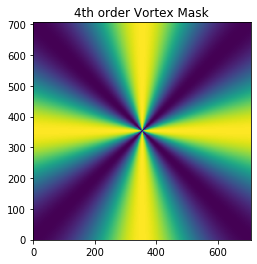

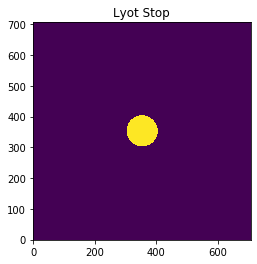

In [7]:
# Q5 answer here
planet = 3.0
star = 0.0
n = 4.

A_star = obscure_pupil(0.0)

A_planet = np.copy(A_star)
A_planet *= np.sqrt(1e-4)

#planet
planet_phase = phi_ramp(A_star,planet,0.0)
A_planet *= np.exp(1j*planet_phase)

#star
star_phase = phi_ramp(A_star,star,0.0)
A_star *= np.exp(1j*star_phase)

r,t = r_theta(padcplx(np.ones(A_star.shape),pad = nsamp),
              dtel_samp/2,dtel_samp/2)

vortex = np.exp(1j*n*t)
plt.title(str(int(n))+'th order Vortex Mask')
plt.imshow(np.real(vortex))
plt.show()

N_lyot = circle_mask(padcplx(np.ones(A_star.shape),pad = nsamp), dtel_samp/2,
                    dtel_samp/2,dtel/2)

plt.title('Lyot Stop')
plt.imshow(N_lyot)
plt.show()

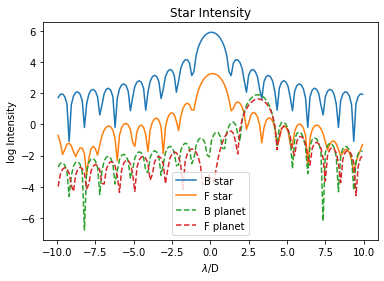

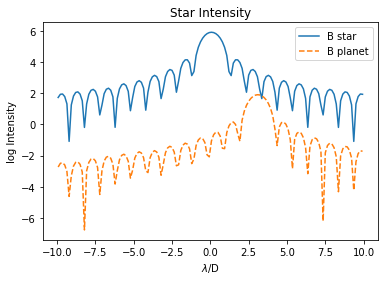

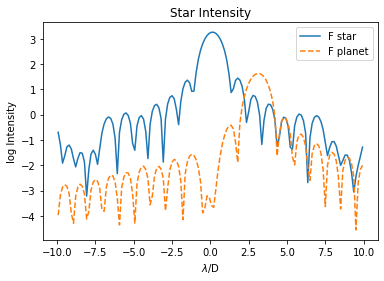

In [8]:
B_star, F_star = coro(A_star,vortex,N_lyot,nsamp)[0::4]
B_cut, F_cut = xaxis_energy(B_star,10*nsamp), xaxis_energy(F_star,10*nsamp)

#Centering
Bstar_vals = (B_cut[1] - np.median(B_cut[1])) / nsamp

plt.plot(Bstar_vals,np.log10(B_cut[0]), label = 'B star')
plt.plot(Bstar_vals,np.log10(F_cut[0]), label = 'F star')
plt.ylabel('log Intensity')
plt.xlabel('$\lambda$/D')
plt.title('Star Intensity')
# plt.legend()
# plt.show()

B_planet, F_planet = coro(A_planet, vortex, N_lyot, nsamp)[0::4]
Bcut_planet, Fcut_planet = xaxis_energy(B_planet, 10*nsamp), xaxis_energy(F_planet, 10*nsamp)

#Centering
Bplanet_vals = (Bcut_planet[1] - np.median(B_cut[1])) / nsamp

plt.plot(Bplanet_vals,np.log10(Bcut_planet[0]),'--',label = 'B planet')
plt.plot(Bplanet_vals,np.log10(Fcut_planet[0]),'--',label = 'F planet')
# plt.ylabel('log Intensity')
# plt.xlabel('$\lambda$/D')
# plt.title('Star Intensity')
plt.legend()
plt.show()

plt.plot(Bstar_vals,np.log10(B_cut[0]), label = 'B star')
plt.plot(Bplanet_vals,np.log10(Bcut_planet[0]),'--',label = 'B planet')
plt.ylabel('log Intensity')
plt.xlabel('$\lambda$/D')
plt.title('Star Intensity')
plt.legend()
plt.show()

plt.plot(Bstar_vals,np.log10(F_cut[0]), label = 'F star')
plt.plot(Bplanet_vals,np.log10(Fcut_planet[0]),'--',label = 'F planet')
plt.ylabel('log Intensity')
plt.xlabel('$\lambda$/D')
plt.title('Star Intensity')
plt.legend()
plt.show()

Second pupil plane from star


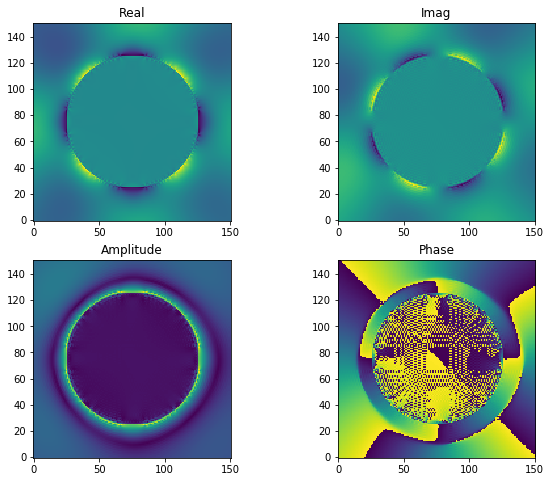

Second pupil plane from planet


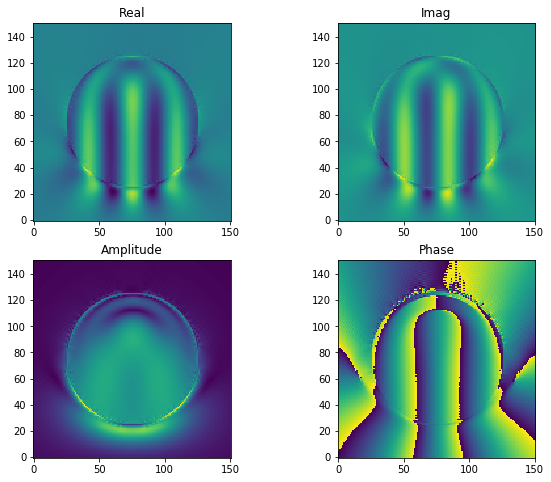

In [9]:
print('Second pupil plane from star')
D_star = coro(A_star,vortex,N_lyot,nsamp)[2]
displC(D_star,151)

print('Second pupil plane from planet')
D_planet = coro(A_planet,vortex,N_lyot,nsamp)[2]
displC(D_planet,151)

## The flux from the star seems to be blocked except for outside of the pupil diameter and a symmetrical distortion pattern.

## For the planet, there seems to there is intensity only on one side of the of the pupil and has amplitude within the aperture.  The pattern is also asymmetric

### The Vortex coronagraph with a secondary obscuration

Repeat the PSF plots from the previous question for the vortex coronagraph but with a 30% secondary obscuration in the telescope.

**Q6 (1 point):** Has the on-axi vortex coronagraph suppression increased or decreased? 

**Q7 (2 points):** What is the effect of the secondary obscuration in the Lyot stop plane?


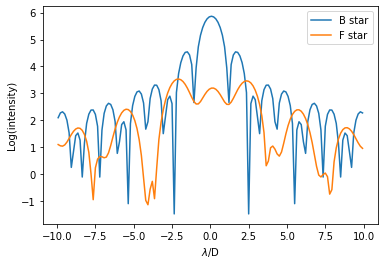

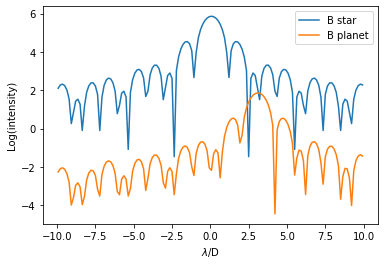

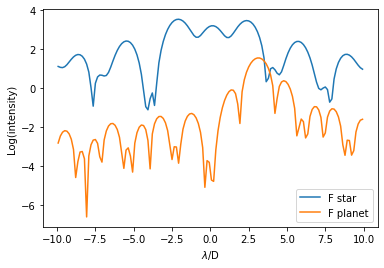

There seems to be about the same on axis supression seems to be the same but seems to be wider


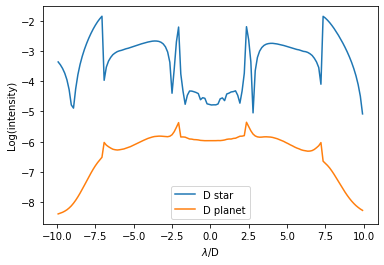

There seems to be a significant drop in intensity after the Lyot stop in both the planet and the star.  Also kinda looks like the batman symbol


In [10]:
# code here

A_star = obscure_pupil(0.3)
A_planet = np.copy(A_star)*np.sqrt(1e-4)

planet_phase = phi_ramp(A_star,planet,0.0)
A_planet *= np.exp(1j*planet_phase)

star_phase = phi_ramp(A_star,star,0.0)
A_star *= np.exp(1j*star_phase)

B_star, F_star = coro(A_star,vortex,N_lyot,nsamp)[0::4]
Bcut_star, Fcut_star = xaxis_energy(B_star,10*nsamp), xaxis_energy(F_star,10*nsamp)

#Centering
Bstar_vals = (Bcut_star[1] - np.median(Bcut_star[1])) / nsamp

plt.plot(Bstar_vals,np.log10(Bcut_star[0]), label = 'B star')
plt.plot(Bstar_vals,np.log10(Fcut_star[0]), label = 'F star')
plt.xlabel('$\lambda$/D')
plt.ylabel('Log(intensity)')
plt.legend()
plt.show()

#planet
B_planet, F_planet = coro(A_planet,vortex,N_lyot,nsamp)[0::4]
Bcut_planet, Fcut_planet = xaxis_energy(B_planet, 10*nsamp), xaxis_energy(F_planet, 10*nsamp)

#Centering
Bplanet_vals = (Bcut_planet[1] - np.median(Bcut_star[1])) / nsamp

#
plt.plot(Bstar_vals,np.log10(Bcut_star[0]), label = 'B star')
plt.plot(Bplanet_vals,np.log10(Bcut_planet[0]), label = 'B planet')
plt.xlabel('$\lambda$/D')
plt.ylabel('Log(intensity)')
plt.legend()
plt.show()

plt.plot(Bstar_vals, np.log10(Fcut_star[0]), label = 'F star')
plt.plot(Bplanet_vals, np.log10(Fcut_planet[0]), label = 'F planet')
plt.xlabel('$\lambda$/D')
plt.ylabel('Log(intensity)')
plt.legend()
plt.show()


# Q6 answer here
print('There seems to be about the same on axis supression seems to be the same but',
     'seems to be wider')

# Q7 answer here
D_star = coro(A_star, vortex, N_lyot,nsamp)[2]
Dcut_star = xaxis_energy(D_star,10*nsamp)
D_planet = coro(A_planet, vortex, N_lyot, nsamp)[2]
Dcut_planet = xaxis_energy(D_planet,10*nsamp)

plt.plot(Bstar_vals, np.log10(Dcut_star[0]),label = 'D star')
plt.plot(Bplanet_vals, np.log10(Dcut_planet[0]), label = 'D planet')
plt.xlabel('$\lambda$/D')
plt.ylabel('Log(intensity)')
plt.legend()
plt.show()


print('There seems to be a significant drop in intensity after the Lyot stop',
     'in both the planet and the star.  Also kinda looks like the batman symbol')

### The APP Coronagraph

The Apodizing Phase Plate (APP) is not a coronagraph in the classical Lyot sense, but it is an apodizer that changes the electric field in the phase but not the amplitude. There is no focal plane mask `m` and you put it in the pupil plane `N`.

Calculate the same plots for star and planet for the APP coronagraph. The APP phase pattern is stored in `app_phse.fits` and the amplitude mask (a 33% secondary obscuration telescope pupil) is in `app_ampl.fits`.


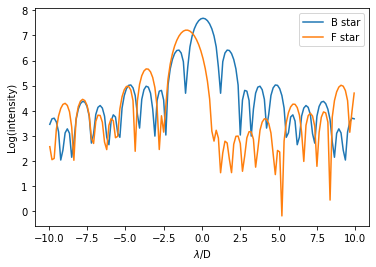

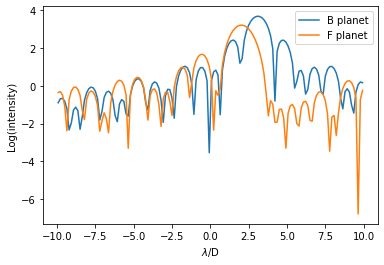

In [11]:
from astropy.io import fits

app_ampl, h1 = fits.getdata('app_ampl.fits',header=True)
app_phse, h2 = fits.getdata('app_phse.fits',header=True)

# code for the PSF plots below here

N_app = np.exp(1j*padcplx(app_phse,pad = nsamp))
m_trans = 1. + padcplx(np.zeros_like(A_star),pad = nsamp)

A_star = app_ampl.astype(np.complex128)

A_planet = np.copy(A_star)*np.sqrt(1e-4)

planet_phase = phi_ramp(A_star,planet,0.0)
A_planet *= np.exp(1j*planet_phase)

#Add Tilt
star_phase = phi_ramp(A_star, star, 0.0)
A_star *= np.exp(1j*star_phase)

B_star, F_star = coro(A_star,m_trans,N_app,nsamp)[0::4]
Bcut_star, Fcut_star = xaxis_energy(B_star,10*nsamp), xaxis_energy(F_star,10*nsamp)

#Centering
Bstar_vals = (Bcut_star[1] - np.median(Bcut_star[1])) / nsamp

#Planet
B_planet, F_planet = coro(A_planet,m_trans,N_app,nsamp)[0::4]
Bcut_planet, Fcut_planet = xaxis_energy(B_planet,10*nsamp), xaxis_energy(F_planet,10*nsamp)

#Centering
Bplanet_vals = (Bcut_planet[1] - np.median(Bcut_star[1])) / nsamp


plt.plot(Bstar_vals,np.log10(Bcut_star[0]),label = 'B star')
plt.plot(Bstar_vals, np.log10(Fcut_star[0]), label = 'F star')
plt.xlabel('$\lambda$/D')
plt.ylabel('Log(intensity)')
plt.legend()
plt.show()

plt.plot(Bplanet_vals,np.log10(Bcut_planet[0]), label = 'B planet')
plt.plot(Bplanet_vals, np.log10(Fcut_planet[0]), label = 'F planet')
plt.xlabel('$\lambda$/D')
plt.ylabel('Log(intensity)')
plt.legend()
plt.show()




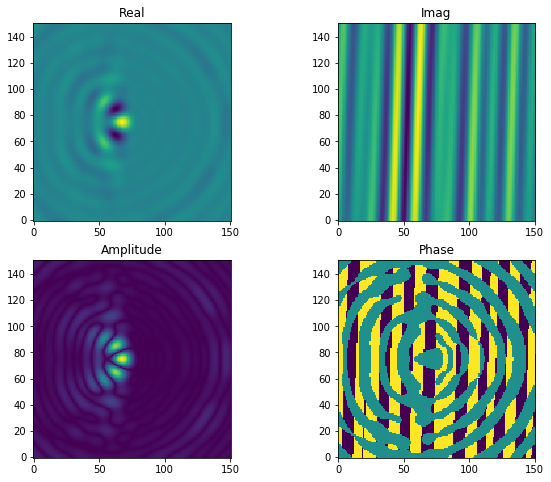

In [12]:
D_star = coro(A_star, m_trans, N_app, nsamp)[4]
displC(D_star,151)

## Adding tip tilt error to the star

Qualitatively describe what happens to the star flux in the Vortex and APP coronagraphs if you add $0.2 \lambda/D$ tilt in the x direction to the star's wavefront. **NOTE:** You can do this by adding the tilt in the code above, then comment it out again when you want the on-axis performance back.

**Q8 (4 points):** What does this say about the tip tilt stability required for each of the coronagraphs?

__Answer Q8:__ The vortex coronagraph has a focal plane element, and is therefore sensitive to tip-tilt errors in the wavefront. In the simulation we can see this as the performance is significantly decreased when adding the overall tip-tilt error in. The APP coronagraph doesn't have a focal plane element, and is therefore insensitive to the tip-tilt error, other than a shift in the detector image. If the tip-tilt error changes during the image, the final star and planet are still _blurred_ but this is a minor price to pay compared to the severe decrease in suppression of focal plane coronagraphs.

However, we note that the APP, as given in this assignment, already contains some tip-tilt, which should be removes at its generation (the planet inherits the same tip-tilt, therefore negating any effect of this mode on the final result; this needs to be taken into account when generating the APP to avoid differences in the generated position of the dark hole vs. the actual position).

*REMEMBER* to make sure your code compiles cleanly before submitting it!

**Please estimate how many hours it took to complete this practicum and put it in the cell below:**

In [13]:
# 8 Hours